# PRETRAINING

Rappresenta il processo di "aggiustamento" dei weights (o trainable parameters) del LLM al fine di migliorare il risultato ottenuto dall'LLM stesso.<br>
E' necessario innanzi tutto riportare i moduli che compongono il modello GTP creati nei notebook precedenti

In [2]:
import torch
import torch.nn as nn

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [3]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [4]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec

In [6]:
class TransformerBlock(nn.Module):
    
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):

        # Shortcut connection for attention block 
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)

        # Add the original input back 
        x = x + shortcut      

        # Shortcut connection for feed forward block 
        shortcut = x         
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)

        
        x = x + shortcut      
        return x

In [7]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        # The device setting will allow us to train the model on a CPU or GPU, depending on which device the input data sits on
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

Per rendere possibile il training senza GPU è stato necessario ridurre context lenght

In [9]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    #  We shorten the context length from 1,024 to 256 tokens. 
    "context_length": 256,  
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12, 
    # It’s possible and common to set dropout to 0. 
    "drop_rate": 0.1,      
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

Riepilogando il processo di generazione di testo:
1) un input in formato testo va in input ad un tokenizer per ottenere una serie di token ID
2) GPT riceve questi token IDs e genera i corrispondenti logits (distribuzione di probabilità per ciascun token del vocab)
3) I logits sono convertiti in token ID che poi sono convertiti dal tokenizer nel testo corrispondete

Reimporto la routine di generazione del testo creata nel notebook precedente

In [10]:
def generate_text_simple(model, 
                         idx,        # idx is a (batch, n_tokens) array of indices in the current context. 
                         max_new_tokens,
                         context_size): 
    for _ in range(max_new_tokens):

        # Crops current context if it exceeds the supported context size,
        # e.g., if LLM supports only 5 tokens, and the context size is 10, then only the last 5 tokens are used as context 
        idx_cond = idx[:, -context_size:]   
        with torch.no_grad():
            logits = model(idx_cond)

        # Focuses only on the last time step, so that (batch, n_token, vocab_size) becomes (batch, vocab_size) 
        logits = logits[:, -1, :]                    
        # probas has shape (batch, vocab_size). 
        probas = torch.softmax(logits, dim=-1)          
        # idx_next has shape (batch, 1). 
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)   
        # Appends sampled index to the running sequence, where idx has shape (batch, n_tokens+1) 
        idx = torch.cat((idx, idx_next), dim=1)    

    return idx

Creo 2 funzioni di utilità per la conversione da testo a token ID e viceversa e le utilizzo per generare testo.<br>
Ovviamente l'output è random in quanto non è stato fatto il training del modello

In [12]:
import tiktoken


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)    #1
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)                #2
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


Per poter effettuare il training è necessario definire una loss function che serve per indirizzare il processo di aggiunstamento dei weights. E' pertanto necessario definire la qualità dell'output prodotto da GPT nel suo compito di predire il prossimo token.

A tal fine prendiamo come esempio 2 input già mappati in tokenid

In [13]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

E i corrispondenti target attesi (gli input shifttati di una posizione). Questo tipo di target è necessario per insegnare al modello a predire il prossimo token

In [15]:
targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107, 588, 11311]])  #  " really like chocolate"]

E' ora possibile passare l'input al modello per ottenere i corrispondenti logits convertiti in probabilità da softmax

In [16]:
# Disables gradient tracking since we are not training yet 
with torch.no_grad():   
    logits = model(inputs)

# Probability of each token in vocabulary 
probas = torch.softmax(logits, dim=-1)     
print(probas.shape)

torch.Size([2, 3, 50257])


Per ottenere il token id successivo applico argmax (estraggo il token con probabilità maggiore) 

In [17]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [18]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
      f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


E' necessario avere una misurazione numerica della qualità dell'output prodotto al fine di poter utilizzare questa misura per il processo di training del modello. A tal fine è necessario misurare quanto "lontani" sono gli output prodotti dai target corretti.<br>
Il processo di training ha infatti l'obiettivo di modificare i wheights del modello per far si che la distanza tra output e target diminuisca il più possibile.
Obiettivo del training è quindo quello di massimizzare la probabilità assegnata al tokenID presente nella posizione corrispondete al target corretto.

Di seguito le probabilità assegnate inizialmente ai target token.

In [19]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


Obiettivo del training è massimizzare la probabilità del token corretto.<br>
Tale obiettivo si ottiene nel corso del training aggiustando i weights grazie al processo di backpropagation


In [20]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


Si calcola log probability invece di probability direttamente in quanto è più facilmente trattabile per il calcolo della media

In [21]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In deep learning si usa diminuire a zero la negative average log probability

In [23]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


Questo valore si chiama CROSS ENTROPY

Ricapitolando le dimensioni sono

In [25]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])



Per utilizzare la funzione Pytorch cross_entropy è necessario accorpare la batch dimension (dimensione 0) con la num tokens dimensione (dimensione 1)

##### logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

In [26]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


E' ora possibile procedere valutando cross_entropy loss per l'intero input (trainig set + validation set).<br>
Innanzi tutto procediamo a caricare il file di input e a verificare il numero di caratteri e di tokens

In [27]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [28]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


Successivamente è necessario dividere il dataset in training e validation set e utilizzare il dataloader creato nel precedente notebbok

In [29]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

Copio la funzione di creazione del dataloader dal notebook 001

In [30]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
    # Initializes the tokenize
    tokenizer = tiktoken.get_encoding("gpt2")                       
    # Creates dataset 
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)   
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        # drop_last=True drops the last batch if it is shorter than the specified batch_size to prevent loss spikes during training. 
        drop_last=drop_last,     
        # The number of CPU processes to use for preprocessing 
        num_workers=num_workers    
    )

    return dataloader

In [32]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        
        # Tokenizes the entire text 
        token_ids = tokenizer.encode(txt)  

        # Uses a sliding window to chunk the book into overlapping sequences of max_length 
        for i in range(0, len(token_ids) - max_length, stride):    
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    
    # Returns the total number of rows in the dataset 
    def __len__(self):  
        return len(self.input_ids)

    # Returns a single row from the dataset 
    def __getitem__(self, idx):         #4
        return self.input_ids[idx], self.target_ids[idx]


In [33]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [34]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


Creo una utility function per calcolare cross_entropy loss per un singolo batch caricato col dataloader

In [37]:
def calc_loss_batch(input_batch, target_batch, model, device):

    # The transfer to a given device allows us to transfer the data to a GPU. 
    input_batch = input_batch.to(device)         
    target_batch = target_batch.to(device)      
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

Creo un'altra utility function per calcolare loss per tutti i batch caricati con un dataloader

In [38]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:

        # Iteratives over all batches if no fixed num_batches is specified 
        num_batches = len(data_loader)     
    else:

        # Reduces the number of batches to match the total number of batches in the data loader 
        # if num_batches exceeds the number of batches in the data loader 
        num_batches = min(num_batches, len(data_loader))   
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            # Sums loss for each batch 
            total_loss += loss.item()   
        else:
            break

    # Averages the loss over all batches 
    return total_loss / num_batches    

Applico la funzione al train e validation dataset

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code. 
model.to(device)   

# Disables gradient tracking for efficiency because we are not training yet
with torch.no_grad():                                        

    # Via the “device” setting, we ensure the data is loaded onto the same device as the LLM model. 
    train_loss = calc_loss_loader(train_loader, model, device)   
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583584255642
Validation loss: 10.98110580444336


# Training Loop
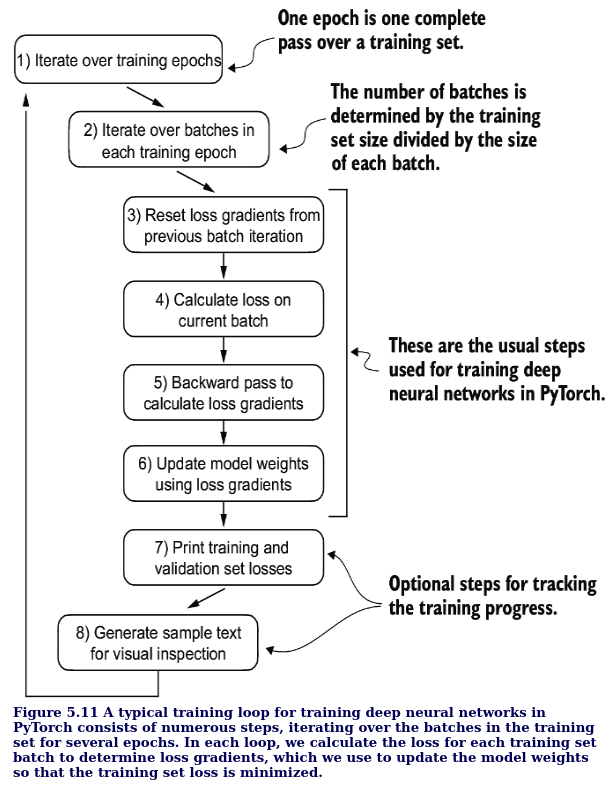

In [44]:
def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    
    # initializes lists to track losses and tokens seen 
    train_losses, val_losses, track_tokens_seen = [], [], []   
    tokens_seen, global_step = 0, -1

    # Starts the main training loop
    for epoch in range(num_epochs):    
        model.train()
        for input_batch, target_batch in train_loader:

            # Resets loss gradients from the previous batch iteration 
            optimizer.zero_grad()  
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            # Calculates loss gradients 
            loss.backward()                     
            # Updates model weights using loss gradients 
            optimizer.step()                    
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step 
            if global_step % eval_freq == 0:   
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )

        # Prints a sample text after each epoch 
        generate_and_print_sample(                      
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen

Funzione che calcola loss su training e validation set durante il training

In [45]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):

    # Dropout is disabled during evaluation for stable, reproducible results. 
    model.eval() 

    #  Disables gradient tracking, which is not required during evaluation, to reduce the computational overhead 
    with torch.no_grad():                              
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

Funzione che stampa un esempio di testo prodotto per vedere come migliora l'output del modello durante il training

In [46]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)

    # Compact print format 
    print(decoded_text.replace("\n", " "))      #1
    model.train()

E' ora finalmente possibile effettuare il training del GPT per 10 epochs e usando ADAMW optimizer

In [47]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
     model.parameters(),           #1
    lr=0.0004, weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Ep 1 (Step 000005): Train loss 7.985, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.753, Val loss 7.048
Ep 2 (Step 000015): Train loss 6.114, Val loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Ep 3 (Step 000020): Train loss 5.525, Val loss 6.490
Ep 3 (Step 000025): Train loss 5.324, Val loss 6.387
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Ep 4 (Step 000030): Train loss 4.761, Val loss 6.360
Ep 4 (Step 000035): Train loss 4.461, Val loss 6.258
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.833, Val loss 6.196
Every effort moves yo

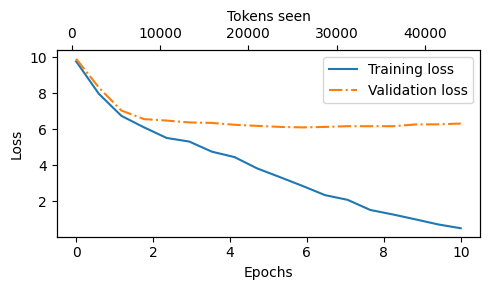

In [48]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()                   #1
    ax2.plot(tokens_seen, train_losses, alpha=0)     #2
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)